## Loading Packages and Functions

Running the following code will allow you to import functions from the code/ folder of the repository. 

In [1]:
import sys
from pathlib import Path

# Automatically detect the repo root by looking for the 'code' folder
current = Path.cwd().resolve()
while current != current.parent:
    if (current / "code").exists():
        repo_root = current
        break
    current = current.parent

# Add repo root to sys.path
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# Add code directory explicitly
code_dir = repo_root / "code"
if str(code_dir) not in sys.path:
    sys.path.insert(0, str(code_dir))

After making sure you can import functions from the code/ folder, run the below cell to import all necessary libraries and functions. 

In [ ]:
# Basic data science packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Package to obtain financial data
import yfinance as yf

# Pretrained sentiment analysis model
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# ML packages
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Dense, Dropout, LayerNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.regularizers import l2

# Import the functions from .py files 
from data_preprocessing import *
from model_preprocessing import *
from model import *

## A Model Demo and Experiment for Market Sector ETF Price Prediction Project

This is a demo notebook that walks you through creating the Market Sector ETF LSTM Model, and specifically experiments with how the LSTM responds to the sentiment data being included in the model's features.

Before training any of the models, the libraries must be loaded and data must be loaded and cleaned. The below code blocks carry out this procedure. A longer description of the data loading and cleaning process is described in the `EDA.ipynb` file. The functions to obtain and clean the data are located in the `data_preprocessing.py` file.

In [ ]:
### Pulling the Data
sectors = ['XLK', 'XLF', 'XLE', 'XLV', 'XLI', 'XLY', 'XLP', 'XLU', 'XLB']

# Obtaining the financial data using Yahoo Finance package
df_financial = download_financial_data()

# Obtaining the news headlines data
df_news = download_news_data()

# Obtaining the news sentiment data using vaderSentiment
df_sentiments = extract_news_sentiment(df_news)

# Merging the two datasets
df_merged = merge_datasets(df_financial, df_sentiments)

# Printing the first 5 rows of the
print("/nFirst 5 rows of the data:")
df_merged.head()


---Financial Data Info---
Date range: 2012-01-30 00:00:00 to 2022-09-21 00:00:00
Total trading days: 2680
Number of sectors in data: 9
Number of features per sector: 15
Total number of financial features: 45

---Raw News Data Info---
Date range: 2012-01-28 00:00:00 to 2022-09-23 00:00:00
Number of headlines: 18178

---News Sentiments Data Info---
Date range: 2012-01-28 00:00:00 to 2022-09-23 00:00:00
Extracted sentiment features: ['sentiment', 'sentiment_std', 'num_headlines']

---Merged Data Info---
Date range: 2012-01-30 00:00:00 to 2022-09-21 00:00:00
Number of trading days: 2680
Total number of features: 48
/nFirst 5 rows of the data:


,XLK_Open,XLK_High,XLK_Low,XLK_Close,XLK_Volume,XLF_Open,XLF_High,XLF_Low,XLF_Close,XLF_Volume,...,XLU_Close,XLU_Volume,XLB_Open,XLB_High,XLB_Low,XLB_Close,XLB_Volume,sentiment,sentiment_std,num_headlines
2012-01-30,22.201755,22.493117,22.185106,22.459818,7691200,8.809803,8.847640,8.753046,8.828721,71714490,...,21.746708,9475100,27.621655,28.119478,27.561314,28.013880,9225700,0.013542,0.288858,18.5
2012-01-31,22.609665,22.617990,22.368252,22.501446,8089300,8.885480,8.898093,8.803499,8.866561,82584343,...,21.853838,7359900,28.240165,28.308050,27.772514,28.044054,11363800,0.013542,0.288858,18.5
2012-02-01,22.717886,22.826106,22.634640,22.726210,8972400,8.942232,9.068357,8.942232,9.005295,87912357,...,21.929453,8196500,28.270332,28.504160,28.255246,28.323132,15190200,0.013542,0.288858,18.5
2012-02-02,22.809452,22.876049,22.726205,22.784479,6020500,9.036829,9.087279,8.986381,9.049442,65660186,...,21.891649,8038600,28.398555,28.489067,28.172269,28.187355,7593200,0.013542,0.288858,18.5
2012-02-03,22.975945,23.117464,22.934321,23.075840,7393200,9.200791,9.295384,9.188179,9.295384,106830735,...,21.948368,9231500,28.556958,28.639929,28.375931,28.572044,9877900,-0.063106,0.273476,17.0


We've retained all the features necessary for the model, which are visible in the above dataframe.

Now, we can carry out an experiment. One of the main points of analysis for this project is determining how useful market/news sentiment is in predicting future stock prices. We can create two models: one that takes in only the financial data (prices and volumes for all of the 9 ETFs) and another that takes in the financial data and news sentiment data (sentiment means and standard deviations and the number of daily headlines).

Before creating any models for the experiment, there are a few more important preprocessing steps including the train-val-test split, the target and feature standardization, and the creation of sequences to pass through the LSTM model. Below is a more detailed description of these steps:

1. **Train-val-test split:** for this experiment, the chosen data split is 70%, 15%, 15% for train, val and test sets respectively. The val set is necessary for model callbacks like EarlyStopping, and the test set provides a way to evaluate the model with unbiased evaluation metrics. Since this is a time-series problem, there is no data shuffling before the split occurs. Instead, the training data is the first 70% of dates, the val data is the next 15% of dates, and the test set is the last 15% of dates.
2. **Target standardization:** the target for this model is a 9-dimensional vector containing the 9 ETF Close prices. These values are standardized using 100-day rolling means and standard deviations. Theese rolling statistics are saved, as they will be used to inverse-transform the predictions before calculating evaluation metrics.
3. **Creation of data sequences:** This step is crucial to the LSTM architecture, as it allows the model to use the previous day's feature values to predict the current day's prices. For this experiment, the look-back window is 60 days, meaning that 60 days worth of data will be used to predict the 61st day's Closing price. The look-back value of 60 is large for a typical LSTM time-series model, however it was chosen so that the model can incorporate a long history of stock and sentiment data while making predictions. Although this increases the model's computational complexity, the model still trains in a reasonable amount of time on a GPU. Additionally, feature standardization is conducted in this step, with each data window's mean and standard deviations used for scaling the features.


The above steps will be carried out twice in the following code cells - once for the model using only financial data, and once for the model using financial and sentiment data.



In [ ]:
# specifying the look_back window for sequences
look_back = 60

In [ ]:
### First: using financial data only

# Train-val-test split
train_finance, val_finance, test_finance = train_val_test_split(df_financial)

# Target standardization
train_scaled_finance, val_scaled_finance, test_scaled_finance, rolling_stats_finance = target_standardization(df_financial, train_finance, val_finance, test_finance)

# Sequence creation
X_train_finance, y_train_finance = create_sequences(train_scaled_finance, look_back=look_back)
X_val_finance, y_val_finance = create_sequences(val_scaled_finance, look_back=look_back)
X_test_finance, y_test_finance = create_sequences(test_scaled_finance, look_back=look_back)


---Train-Val-Test Split Info---
Train size: 1875
Validation size: 403
Test size: 402

---Target Standardization Info---
Train size: 1875
Validation size: 403
Test size: 402
Rolling statistics have been stored.

---Sequences have been created---
X shape is: (1815, 60, 45)
y shape is: (1815, 9)

---Sequences have been created---
X shape is: (343, 60, 45)
y shape is: (343, 9)

---Sequences have been created---
X shape is: (342, 60, 45)
y shape is: (342, 9)


In [ ]:
### Second: Using financial and sentiment data (full dataset)

# Train-val-test split
train_full, val_full, test_full = train_val_test_split(df_merged)

# Target standardization
train_scaled_full, val_scaled_full, test_scaled_full, rolling_stats_full = target_standardization(df_merged, train_full, val_full, test_full)

# Sequence creation
X_train_full, y_train_full = create_sequences(train_scaled_full, look_back=look_back)
X_val_full, y_val_full = create_sequences(val_scaled_full, look_back=look_back)
X_test_full, y_test_full = create_sequences(test_scaled_full, look_back=look_back)


---Train-Val-Test Split Info---
Train size: 1875
Validation size: 403
Test size: 402

---Target Standardization Info---
Train size: 1875
Validation size: 403
Test size: 402
Rolling statistics have been stored.

---Sequences have been created---
X shape is: (1815, 60, 48)
y shape is: (1815, 9)

---Sequences have been created---
X shape is: (343, 60, 48)
y shape is: (343, 9)

---Sequences have been created---
X shape is: (342, 60, 48)
y shape is: (342, 9)


In [ ]:
# Callbacks for both models
callbacks = [

    # Early Stopping to reduce overfitting and restoring the weights from the best epoch
    EarlyStopping(
      monitor = "val_loss",
      patience = 10,
      restore_best_weights = True
    ),

    # Reduce learning rate when validation loss plateaus for more finely tuned optimization
    ReduceLROnPlateau(
      monitor='val_loss',
      factor=0.5,
      patience=5,
      min_lr=1e-6,
      verbose=1
    )

]

Now, both of the models's summaries are displayed, they are trained, and some evaluation metrics are displayed.

Starting with the finance-only model:

In [ ]:
# Creating the model
finance_only_model = stock_prediction_model(X_train_finance)

# Displaying the model's summary
finance_only_model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 60, 45)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 60, 256)        │       309,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515,209 (1.97 MB)

 Trainable params: 515,209 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the finance-only model
history_finance = finance_only_model.fit(
    X_train_finance, y_train_finance,
    validation_data=(X_val_finance, y_val_finance),
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.1742 - rmse: 1.0289 - val_loss: 0.6325 - val_rmse: 0.7203 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6052 - rmse: 0.7225 - val_loss: 0.4477 - val_rmse: 0.6660 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4548 - rmse: 0.6808 - val_loss: 0.3644 - val_rmse: 0.6328 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3794 - rmse: 0.6518 - val_loss: 0.3214 - val_rmse: 0.6251 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.3334 - rmse: 0.6260 - val_loss: 0.2933 - val_rmse: 0.6243 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3041 - rmse: 0.6140 - val_loss: 0.2661 - val_rmse: 0.5928 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2874 - rmse: 0.6176 - val_loss: 0.2453 - val_rmse: 0.5837 - learning_rate:

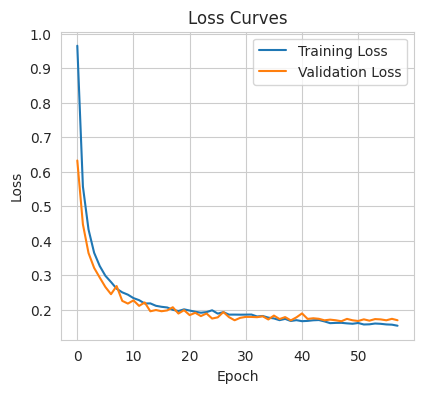

In [ ]:
### ------- Learning Curves -------
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_finance.history['loss'], label='Training Loss')
plt.plot(history_finance.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

In [ ]:
### Financial-data-model evaluation

# Making predictions on the test set
y_pred_test_finance = finance_only_model.predict(X_test_finance, verbose=0)

# Looping through the sectors to calculate results
results_finance = {}
for i, sector in enumerate(sectors):

    # Inverse transformations on test predictions and test set
    y_pred_inverse = y_pred_test_finance[:, i] * rolling_stats_finance[sector]['std_test'][look_back:] + rolling_stats_finance[sector]['mean_test'][look_back:]
    y_test_inverse = y_test_finance[:, i] * rolling_stats_finance[sector]['std_test'][look_back:] + rolling_stats_finance[sector]['mean_test'][look_back:]

    # Calculating metrics and storing
    rmse = root_mean_squared_error(y_test_inverse, y_pred_inverse)
    r2 = r2_score(y_test_inverse, y_pred_inverse)
    results_finance[sector] = {
        'rmse': rmse,
        'r2': r2
    }

# Converting the results to a dataframe
results_df_finance = pd.DataFrame(results_finance).loc[['rmse', 'r2'], :].T

# Printing out the results
print("\nFinance-only-data Model Results:")
results_df_finance




Finance-only-data Model Results:


,rmse,r2
XLK,6.049788,0.738399
XLF,0.898779,0.850700
XLE,4.304485,0.862040
XLV,2.239859,0.731832
XLI,2.075077,0.812024
XLY,7.058599,0.836282
XLP,1.077031,0.846554
XLU,1.258937,0.896935
XLB,1.730921,0.814800


Relatively high values of $R^2$ (>0.7) are achieved for all sectors. Next, we will repeat the process using the full dataset and compare how the results have changed.

In [ ]:
# Creating the financial + sentiment model
full_model = stock_prediction_model(X_train_full)

# Displaying the model's summary
full_model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 60, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 60, 256)        │       312,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 518,281 (1.98 MB)

 Trainable params: 518,281 (1.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the finance-only model
history_full = full_model.fit(
    X_train_full, y_train_full,
    validation_data=(X_val_full, y_val_full),
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.2245 - rmse: 1.0761 - val_loss: 0.6522 - val_rmse: 0.7546 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6195 - rmse: 0.7464 - val_loss: 0.4550 - val_rmse: 0.6724 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4638 - rmse: 0.6982 - val_loss: 0.3812 - val_rmse: 0.6672 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3832 - rmse: 0.6553 - val_loss: 0.3328 - val_rmse: 0.6415 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3282 - rmse: 0.6137 - val_loss: 0.2960 - val_rmse: 0.6226 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3038 - rmse: 0.6124 - val_loss: 0.2768 - val_rmse: 0.6075 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2927 - rmse: 0.6206 - val_loss: 0.2463 - val_rmse: 0.5745 - learning_rate:

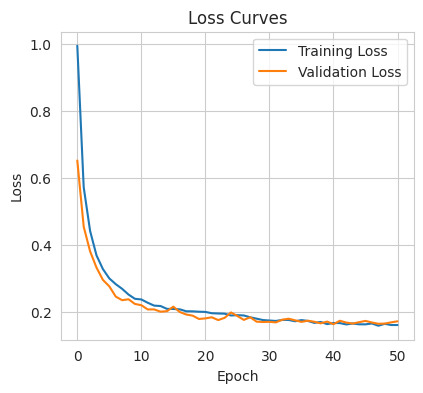

In [ ]:
### ------- Learning Curves -------
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_full.history['loss'], label='Training Loss')
plt.plot(history_full.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

In [ ]:
### Full-data-model evaluation

# Making predictions on the test set
y_pred_test_full = full_model.predict(X_test_full, verbose=0)

# Looping through the sectors to calculate results
results_full = {}
for i, sector in enumerate(sectors):

    # Inverse transformations on test predictions and test set
    y_pred_inverse = y_pred_test_full[:, i] * rolling_stats_full[sector]['std_test'][look_back:] + rolling_stats_full[sector]['mean_test'][look_back:]
    y_test_inverse = y_test_full[:, i] * rolling_stats_full[sector]['std_test'][look_back:] + rolling_stats_full[sector]['mean_test'][look_back:]

    # Calculating metrics and storing
    rmse = root_mean_squared_error(y_test_inverse, y_pred_inverse)
    r2 = r2_score(y_test_inverse, y_pred_inverse)
    results_full[sector] = {
        'rmse': rmse,
        'r2': r2
    }

# Converting the results to a dataframe
results_df_full = pd.DataFrame(results_full).loc[['rmse', 'r2'], :].T

# Printing out the results
print("\nFull-data Model Results:")
results_df_full


Full-data Model Results:


,rmse,r2
XLK,6.006031,0.742170
XLF,0.869297,0.860334
XLE,4.060429,0.877240
XLV,2.154601,0.751859
XLI,2.208416,0.787091
XLY,7.347784,0.822592
XLP,0.988114,0.870844
XLU,1.139684,0.915535
XLB,1.663026,0.829043


Looking at the results above, it seems as though adding the news sentiment data has improved the test results for many of the ETFs. The plots below further quantify the improvements made as a result of the sentiment data.

In [ ]:
# Renaming the columns of both results dataframes for clarity
results_df_finance.rename(columns={'rmse':'rmse_without', 'r2':'r2_without'}, inplace=True)
results_df_full.rename(columns={'rmse':'rmse_with', 'r2':'r2_with'}, inplace=True)

# Concatenating the two results dataframes
results_df = pd.concat([results_df_finance, results_df_full], axis=1)

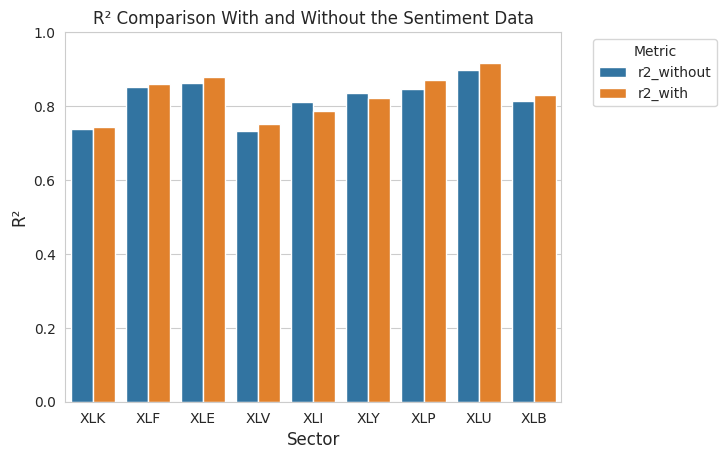

In [ ]:
### Creating a plot that compares the R^2s before and after adding sentiment data

# Melting before plotting
r2_df_reindexed = results_df[['r2_without', 'r2_with']].reset_index()
r2_df_melted = r2_df_reindexed.melt(id_vars="index", value_vars = ['r2_without', 'r2_with'], var_name = "metric", value_name = 'r2')

# Making a dual-barplot
sns.barplot(
    data = r2_df_melted,
    x = 'index',
    y = 'r2',
    hue = 'metric',
    palette = ['#1f77b4', '#ff7f0e']
)
plt.title("R² Comparison With and Without the Sentiment Data", fontsize=12)
plt.xlabel("Sector", fontsize=12)
plt.ylabel("R²", fontsize=12)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1))
plt.ylim(0,1);

plt.savefig("r2_improvements.jpeg", bbox_inches='tight')
